# Time series analysis as supervised learning

The remaining parts of the project will build models for time series data using Keras.

We will be using the mortgage affordability provided by Zillow https://www.zillow.com/research/data/ we have seen previously.

The project repository includes the data and utility functions to load and plot it

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import affordability_lib.utils as utils

afford_df = utils.get_affordability_df()
afford_df.head(10)

,RegionID,RegionName,SizeRank,1979-03,1979-06,1979-09,1979-12,1980-03,1980-06,1980-09,...,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03
324,394913,"New York, NY",1,0.261700,0.278316,0.284399,0.319438,0.379845,0.318970,0.337586,...,0.241961,0.240494,0.247387,0.245957,0.249606,0.241544,0.239503,0.240021,0.265376,0.269264
325,753899,"Los Angeles-Long Beach-Anaheim, CA",2,0.357694,0.388161,0.401762,0.459422,0.541508,0.464528,0.486750,...,0.383162,0.382531,0.396277,0.395686,0.402116,0.393042,0.390708,0.386895,0.430334,0.433476
326,394463,"Chicago, IL",3,0.261928,0.276790,0.276248,0.309709,0.353099,0.299344,0.295616,...,0.134913,0.134063,0.139074,0.137962,0.138784,0.134412,0.133701,0.132856,0.147025,0.149054
327,394514,"Dallas-Fort Worth, TX",4,0.301131,0.328453,0.340857,0.386321,0.452818,0.376912,0.394715,...,0.118163,0.117663,0.124935,0.128167,0.133517,0.131539,0.133219,0.135142,0.149861,0.152387
328,394974,"Philadelphia, PA",5,0.204333,0.215107,0.219247,0.247690,0.295396,0.248018,0.260259,...,0.141915,0.139100,0.142831,0.141625,0.142089,0.137387,0.135599,0.135064,0.148746,0.148559
329,394692,"Houston, TX",6,0.243178,0.265630,0.268049,0.294382,0.342770,0.291661,0.292763,...,0.112149,0.113520,0.118255,0.119155,0.122370,0.120863,0.120717,0.120675,0.132078,0.130511
330,395209,"Washington, DC",7,0.254252,0.264869,0.277353,0.314773,0.373035,0.319475,0.337635,...,0.174821,0.173381,0.178910,0.177032,0.178584,0.172367,0.169965,0.168010,0.185774,0.186239
331,394856,"Miami-Fort Lauderdale, FL",8,0.267852,0.284229,0.287053,0.332037,0.392403,0.334098,0.360938,...,0.181766,0.183585,0.194088,0.197580,0.203430,0.197855,0.198292,0.199508,0.221129,0.222176
332,394347,"Atlanta, GA",9,0.248301,0.264578,0.271742,0.312490,0.371988,0.307385,0.322451,...,0.113326,0.113214,0.117454,0.118066,0.120754,0.117895,0.117187,0.116937,0.130104,0.131081
333,394404,"Boston, MA",10,0.222021,0.237248,0.239940,0.276893,0.316496,0.271210,0.285134,...,0.212892,0.210786,0.216809,0.217371,0.221722,0.215844,0.214103,0.212644,0.236357,0.239656


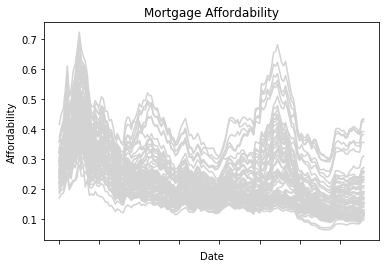

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
utils.plot_affordability_series(afford_df)
plt.show()

## Getting data ready

We will build models that forecast mortgage one-year-out affordability based on the previous 4 years of affordability values. To obtain data for model building we provide the class `TSExampleGenerator` in the `affordability_lib.utils` module. This class does a bunch of things so let's take a look by parts.

First, let's initialize the object. Here, we will set important parameters for our model building. We'll explain the parameters below

In [4]:
from affordability_lib.utils import TSExampleGenerator
example_generator_factory = TSExampleGenerator(afford_df, horizon=4, n_prediction_years=4,
                                      n_test_quarters = 4, n_val_quarters=4,
                                      normalize=True)


The parameters we pass have the following purpose:
- `afford_df`: the affordability data frame
- `horizon=4`: how far from the last observed timepoint do we make predictions, since we are making one-year-out predictions, we have a 4 quarter horizon
- `n_prediction_years`: how many years of data we use to make predictions, here we use 4 years, which gives us 16 total time points to use for predictions. Therefore, we have sequences of length 16, to make predictions of sequences of length 1
- `n_test_quarters`: we split the dataset into train, validation and test, here we specify that the **last four quarters** of data are to be used as targets for testing
- `n_val_quarters`: here we set that the four quarters preceeding the quarters above will be used as targets for validation, all the remaning data will be used for training
- `normalize`: standardize timeseries for each region by centering and scaling using region-specific mean and standard deviation. These parameters are computed from the training portion of the sequences only.

Once we have the object above we can get generators for the training, validation and testing portions of the dataset as follows:

In [5]:
# get generator for testing portion of dataset
test_generator, num_test_steps = example_generator_factory.get_test_gen(batchsize=20)
print(test_generator)
print(num_test_steps)

<generator object _example_generator at 0x000002C85547C200>
15


The above states that `test_generator` is a python generator. These are objects we can use in iterations using the `next` keyword. For example, to get a batch of 20 test sequences I can do the following:

In [6]:
X, y = next(test_generator)
print(X.shape)
print(y.shape)

(20, 16, 1)
(20,)


Note that the shape of `X` has three dimensions because sequence models in keras require it. The first dimension is the number of sequences, the second dimension the number of steps in the sequence (time), and the third dimension the dimensionality of the observations at each timestep (here 1 since we only observe affordability, in other situations this could be a multidimensional vector).


The way this code is designed, we can call the `next` keyword on these generators infinitely as it is easier to use within keras that way. The `num_test_steps` returned above is used to ensure that we generate enough examples to cycle through at least once through the corresponding portion of the dataset. For instance, the following loop generates all test examples in the dataset.

In [7]:
for i in range(num_test_steps):
    X, y = next(test_generator)

## Baseline model

To get a sense of the problem, let's use a baseline model that uses average mortgage affordability over the previous four years to predict one-year-out affordability. Let's try this model on the validation dataset and compute it's median absolute error.

In [8]:
import numpy as np

def evaluate_naive():
    batch_maes = []
    gen, num_steps = example_generator_factory.get_val_gen(batchsize=20)
    for step in range(num_steps):
        X, y = next(gen)
        yhat = np.mean(X, axis=1)
        mae = np.median(np.abs(y - yhat))
        batch_maes.append(mae)
    return batch_maes

naive_maes = evaluate_naive()
print(np.mean(naive_maes))
print(np.std(naive_maes))

0.27454311314151586
0.05348667369435827


## Model building

Let's build a few models for this task using keras. For all of these use `RMSprop` as the gradient descent algorithm, and `median absolute error` as the loss function. For each of the model plot training and validation error across epochs and comment on their behavior. Is the model learning anything, is it overfitting, how stable is it, etc. For each model, report median absolute error on the validation set.

### Model 1: Linear Regression 

Train a linear regression model using Keras for this task.

- Recall that for linear regression we want to build a model

$$
f = Xw + b
$$ 

where in this case, $X$ will be a matrix with 16 columns, corresponding to the values of affordability for the previous four years.

The first layer in your network will be a `Flatten` layer since this is not a sequence model. This is true of the next two models as well. 

The general structure of your models will be as follows:

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
#model.add( layer that implement your models )
model.add(layers.Dense(1, input_shape=(16,1), activation='linear'))
#model.add( potentially more layers)

model.compile(optimizer=RMSprop(), loss='mae')
    
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)


history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

# you can use history to make plots of training and validation error
# after that you can make predictions with model.predict

# Print Model Summary
print(model.summary())


Epoch 1/20
540/540 [==============================] - 2s 3ms/step - loss: 0.4081 - val_loss: 0.1043
Epoch 2/20
540/540 [==============================] - 0s 839us/step - loss: 0.0930 - val_loss: 0.1426
Epoch 3/20
540/540 [==============================] - 0s 810us/step - loss: 0.0702 - val_loss: 0.1641
Epoch 4/20
540/540 [==============================] - 0s 810us/step - loss: 0.0694 - val_loss: 0.1657
Epoch 5/20
540/540 [==============================] - 0s 810us/step - loss: 0.0692 - val_loss: 0.1722
Epoch 6/20
540/540 [==============================] - 0s 897us/step - loss: 0.0690 - val_loss: 0.1726
Epoch 7/20
540/540 [==============================] - 0s 868us/step - loss: 0.0687 - val_loss: 0.1783
Epoch 8/20
540/540 [==============================] - 0s 868us/step - loss: 0.0684 - val_loss: 0.1758
Epoch 9/20
540/540 [==============================] - 0s 868us/step - loss: 0.0681 - val_loss: 0.1831
Epoch 10/20
540/540 [==============================] - 0s 839us/step - loss: 0.0679 

Mean Validation Loss: 0.17732154566794633
Std. Validation Loss: 0.021030620770462236


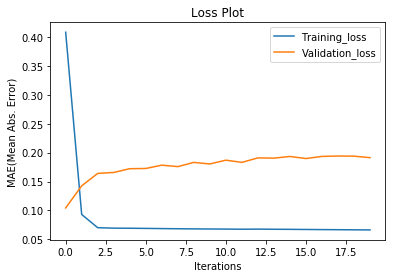

In [17]:

# Plot Training and Validation process for Model 1

plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.title("Loss Plot")
plt.xlabel('Iterations')
plt.ylabel('MAE(Mean Abs. Error)')
plt.legend()



# Report Median absolute error on the validation set

print("Mean Validation Loss:", np.mean(history.history['val_loss']))
print("Std. Validation Loss:", np.std(history.history['val_loss']))


*Comment: Since the Training Loss dropped so quick, it's an abvious sign of ovefitting. For an training process the loss should slowly decrease.  

### Model 2: Single Layer Feed-Forward Neural Network

Train a single layer feed forward neural network using Keras.

Don't worry about tuning parameters yet (i.e., the number of units in the hidden layer units). Choose a number and go with it.


In [19]:
n_h=5    #Number of neurons in hidden layer

model = Sequential()
model.add(layers.Flatten(input_shape=(16,1)))
model.add(layers.Dense(n_h, activation='tanh')) 
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
   
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

# Print Model Summary
print(model.summary())

Epoch 1/20
540/540 [==============================] - 1s 1ms/step - loss: 0.3004 - val_loss: 0.1769
Epoch 2/20
540/540 [==============================] - 0s 839us/step - loss: 0.0736 - val_loss: 0.2856
Epoch 3/20
540/540 [==============================] - 0s 868us/step - loss: 0.0643 - val_loss: 0.2793
Epoch 4/20
540/540 [==============================] - 0s 868us/step - loss: 0.0633 - val_loss: 0.2626
Epoch 5/20
540/540 [==============================] - 0s 868us/step - loss: 0.0625 - val_loss: 0.2467
Epoch 6/20
540/540 [==============================] - 0s 839us/step - loss: 0.0618 - val_loss: 0.2562
Epoch 7/20
540/540 [==============================] - 0s 897us/step - loss: 0.0615 - val_loss: 0.2481
Epoch 8/20
540/540 [==============================] - 0s 868us/step - loss: 0.0609 - val_loss: 0.2371
Epoch 9/20
540/540 [==============================] - 0s 868us/step - loss: 0.0605 - val_loss: 0.2421
Epoch 10/20
540/540 [==============================] - 0s 839us/step - loss: 0.0602 

Mean Validation Loss: 0.2193675396591425
Std. Validation Loss: 0.03564277973259686


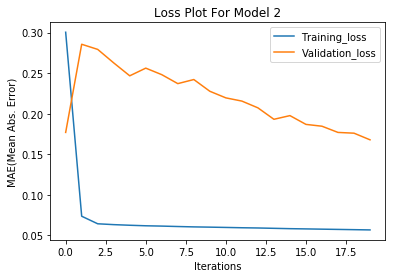

In [20]:

# Plot Training and Validation process for Model 2

plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.title("Loss Plot For Model 2")
plt.xlabel('Iterations')
plt.ylabel('MAE(Mean Abs. Error)')
plt.legend()



# Report Median absolute error on the validation set

print("Mean Validation Loss:", np.mean(history.history['val_loss']))
print("Std. Validation Loss:", np.std(history.history['val_loss']))


*Comment: Even though the plot of training loss still shows ovefitting, the validation plot has got smoother and shows the the learning process for Model 2 is far better than the first model. 

### Model 3: Deep Neural Network

Train a neural network with one or more layers for this task. 

Here, try tuning parameters (the number of hidden layers, and the number of units per layer). Use MAE on validation set as a guide.

In [24]:
tloss=[]   # List of MAE of trainning loss per n_h
vloss=[]   # List of MAE of validation loss per n_h


n_h=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]    #List of number of neurons in hidden layer

for i in n_h:
    
    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(i, activation='tanh'))
    model.add(layers.Dense(1))

    model.compile(optimizer=RMSprop(), loss='mae')
   
    train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
    val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_train_steps,
                                  epochs=20, # however many epochs you plan to use
                                  validation_data=val_gen,
                                  validation_steps=num_val_steps)
    
    tloss.append(np.mean(history.history['loss']))
    vloss.append(np.mean(history.history['val_loss']))

Epoch 1/20
540/540 [==============================] - 1s 1ms/step - loss: 0.2876 - val_loss: 0.2199
Epoch 2/20
540/540 [==============================] - 1s 955us/step - loss: 0.0934 - val_loss: 0.2024
Epoch 3/20
540/540 [==============================] - 0s 926us/step - loss: 0.0669 - val_loss: 0.1631
Epoch 4/20
540/540 [==============================] - 0s 926us/step - loss: 0.0625 - val_loss: 0.1496
Epoch 5/20
540/540 [==============================] - 0s 897us/step - loss: 0.0608 - val_loss: 0.1392
Epoch 6/20
540/540 [==============================] - 0s 926us/step - loss: 0.0602 - val_loss: 0.1316
Epoch 7/20
540/540 [==============================] - 0s 926us/step - loss: 0.0594 - val_loss: 0.1247
Epoch 8/20
540/540 [==============================] - 0s 926us/step - loss: 0.0588 - val_loss: 0.1198
Epoch 9/20
540/540 [==============================] - 1s 955us/step - loss: 0.0582 - val_loss: 0.1056
Epoch 10/20
540/540 [==============================] - 1s 955us/step - loss: 0.0576 

540/540 [==============================] - 1s 2ms/step - loss: 0.2330 - val_loss: 0.1130
Epoch 2/20
540/540 [==============================] - 0s 926us/step - loss: 0.0777 - val_loss: 0.1752
Epoch 3/20
540/540 [==============================] - 1s 984us/step - loss: 0.0717 - val_loss: 0.1694
Epoch 4/20
540/540 [==============================] - 1s 955us/step - loss: 0.0702 - val_loss: 0.1572
Epoch 5/20
540/540 [==============================] - 1s 955us/step - loss: 0.0685 - val_loss: 0.1568
Epoch 6/20
540/540 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.1533
Epoch 7/20
540/540 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.1527
Epoch 8/20
540/540 [==============================] - 1s 955us/step - loss: 0.0643 - val_loss: 0.1443
Epoch 9/20
540/540 [==============================] - 1s 984us/step - loss: 0.0635 - val_loss: 0.1407
Epoch 10/20
540/540 [==============================] - 1s 984us/step - loss: 0.0627 - val_loss: 0.1

540/540 [==============================] - 1s 2ms/step - loss: 0.2162 - val_loss: 0.0989
Epoch 2/20
540/540 [==============================] - 1s 955us/step - loss: 0.0908 - val_loss: 0.1919
Epoch 3/20
540/540 [==============================] - 1s 984us/step - loss: 0.0812 - val_loss: 0.2263
Epoch 4/20
540/540 [==============================] - 1s 984us/step - loss: 0.0769 - val_loss: 0.2177
Epoch 5/20
540/540 [==============================] - 1s 984us/step - loss: 0.0744 - val_loss: 0.1934
Epoch 6/20
540/540 [==============================] - 1s 984us/step - loss: 0.0722 - val_loss: 0.1890
Epoch 7/20
540/540 [==============================] - 1s 984us/step - loss: 0.0704 - val_loss: 0.1945
Epoch 8/20
540/540 [==============================] - 1s 955us/step - loss: 0.0692 - val_loss: 0.1703
Epoch 9/20
540/540 [==============================] - 1s 955us/step - loss: 0.0678 - val_loss: 0.1612
Epoch 10/20
540/540 [==============================] - 1s 984us/step - loss: 0.0668 - val_loss:

Mean Training Loss: [0.07116188710417459, 0.07166079374340673, 0.06922133033301821, 0.07080196566120896, 0.07237900317025682, 0.07316411140098891, 0.07298593556577408, 0.07351593823931009, 0.07619574761294104, 0.07604050236202226]
Mean Validation Loss: [0.1184742877384027, 0.13061039276421071, 0.1111346458643675, 0.19360167130827904, 0.1363122624158859, 0.1693535705655813, 0.1356806590904792, 0.15339396712680659, 0.15460166583458584, 0.16777561873197558]


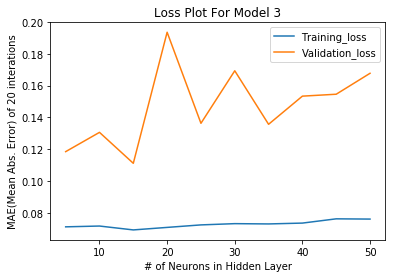

In [27]:
# Plot Training and Validation process for Model 3

plt.plot(n_h, tloss, label='Training_loss')
plt.plot(n_h, vloss,label='Validation_loss')
plt.title("Loss Plot For Model 3")
plt.xlabel('# of Neurons in Hidden Layer')
plt.ylabel('MAE(Mean Abs. Error) of 20 interations')
plt.legend()

# Report Median absolute error on the validation set per n_h

print("Mean Training Loss:", tloss)
print("Mean Validation Loss:", vloss)

*Comment: The smallest MAE over 20 epochs for Validation Loss belongs to the model with 15 neurons in its hidden layer. However, the MAEs for Training Loss still pinpoints overfitting. 

### Model 4: Single layer recurrent neural network

Train a recurrent neural network with a single layer, using a `GRU` recurrent cell. 

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

You will not need a `Flatten` layer in these networks.

In [29]:
n_h=15   #Based on the results from previous model

model = Sequential()
model.add(layers.GRU(n_h, activation='tanh', input_shape=(16,1))) 
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
   
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)


# Print Model Summary
print(model.summary())

Epoch 1/20
540/540 [==============================] - 3s 6ms/step - loss: 0.2713 - val_loss: 0.1228
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0857 - val_loss: 0.1068
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0798 - val_loss: 0.0819
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0771 - val_loss: 0.0852
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0754 - val_loss: 0.0945
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0737 - val_loss: 0.1070
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0698 - val_loss: 0.1373
Epoch 8/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0635 - val_loss: 0.1467
Epoch 9/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0608 - val_loss: 0.1416
Epoch 10/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0595 - val_loss: 0.1416

Mean Validation Loss: 0.11159258550653854
Std. Validation Loss: 0.01944975452855571


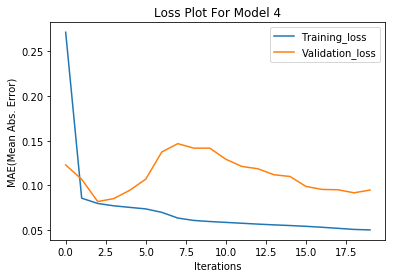

In [30]:
# Plot Training and Validation process for Model 4

plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.title("Loss Plot For Model 4")
plt.xlabel('Iterations')
plt.ylabel('MAE(Mean Abs. Error)')
plt.legend()



# Report Median absolute error on the validation set

print("Mean Validation Loss:", np.mean(history.history['val_loss']))
print("Std. Validation Loss:", np.std(history.history['val_loss']))

*Comment: The elbow point in Trainning loss is losing the sharp shape it used to have. But, overfitting still exists. The MAE for validation loss show an acceptable decrease, which is sign of learning. We are on a correct path.

### Model 5: Single layer recurrent neural network with dropout

Train a recurrent neural network with a single layer, using a GRU recurrent cell.

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

Use the `dropout` and `recurrent_dropout` arguments to implement weight dropout in the RNN. 

In [31]:
n_h=15   #Based on the results from model 3

model = Sequential()
model.add(layers.GRU(n_h, activation='tanh', dropout=0.2 , input_shape=(16,1))) 
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
   
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)


# Print Model Summary
print(model.summary())

Epoch 1/20
540/540 [==============================] - 3s 6ms/step - loss: 0.2609 - val_loss: 0.2041
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1182 - val_loss: 0.1764
Epoch 3/20
540/540 [==============================] - 2s 5ms/step - loss: 0.1133 - val_loss: 0.1785
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1115 - val_loss: 0.1951
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1119 - val_loss: 0.1994
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1100 - val_loss: 0.2101
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1101 - val_loss: 0.1770
Epoch 8/20
540/540 [==============================] - 3s 5ms/step - loss: 0.1068 - val_loss: 0.2166
Epoch 9/20
540/540 [==============================] - 2s 5ms/step - loss: 0.1058 - val_loss: 0.2065
Epoch 10/20
540/540 [==============================] - 2s 5ms/step - loss: 0.1026 - val_loss: 0.2109

Mean Validation Loss: 0.21599941884477936
Std. Validation Loss: 0.02149893617957653


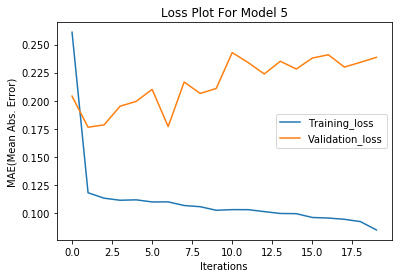

In [32]:
# Plot Training and Validation process for Model 5

plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.title("Loss Plot For Model 5")
plt.xlabel('Iterations')
plt.ylabel('MAE(Mean Abs. Error)')
plt.legend()



# Report Median absolute error on the validation set

print("Mean Validation Loss:", np.mean(history.history['val_loss']))
print("Std. Validation Loss:", np.std(history.history['val_loss']))

*Comment: It seems that adding dropout worsen the validation results we got from Model 4. 

### Model 6: Deep RNN 

Train a recurrent neural network with two or more layers, with or without dropout. Here experiment with number and size of layers using validation error as a guide.

In [34]:
# Using One Hidden Layer

tloss=[]   # List of MAE of trainning loss per n_h
vloss=[]   # List of MAE of validation loss per n_h


n_h=[5, 10, 15, 20, 25, 30]    #List of number of neurons in hidden layer

for i in n_h:
    
    model = Sequential()
    model.add(layers.GRU(i, activation='tanh', input_shape=(16,1))) 
    model.add(layers.Dense(1))
    

    model.compile(optimizer=RMSprop(), loss='mae')
   
    train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
    val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_train_steps,
                                  epochs=20, # however many epochs you plan to use
                                  validation_data=val_gen,
                                  validation_steps=num_val_steps)
    
    tloss.append(np.mean(history.history['loss']))
    vloss.append(np.mean(history.history['val_loss']))


Epoch 1/20
540/540 [==============================] - 3s 6ms/step - loss: 0.3292 - val_loss: 0.1932
Epoch 2/20
540/540 [==============================] - 2s 4ms/step - loss: 0.1106 - val_loss: 0.1586
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0881 - val_loss: 0.1608
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0853 - val_loss: 0.1625
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0842 - val_loss: 0.1623
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0833 - val_loss: 0.1713
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0825 - val_loss: 0.1697
Epoch 8/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0818 - val_loss: 0.1737
Epoch 9/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0811 - val_loss: 0.1725
Epoch 10/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0808 - val_loss: 0.1824

540/540 [==============================] - 2s 4ms/step - loss: 0.0871 - val_loss: 0.0852
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0813 - val_loss: 0.1133
Epoch 4/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0758 - val_loss: 0.1624
Epoch 5/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0675 - val_loss: 0.1593
Epoch 6/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0634 - val_loss: 0.1562
Epoch 7/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0613 - val_loss: 0.1378
Epoch 8/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0597 - val_loss: 0.1228
Epoch 9/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0575 - val_loss: 0.1126
Epoch 10/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0556 - val_loss: 0.1054
Epoch 11/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0547 - val_loss: 0.0991
Epoch 12/

Mean Training Loss: [0.09461878341726132, 0.06914900432754721, 0.06734580015901614, 0.0652742407489913, 0.06683046952148691, 0.06268405393507608]
Mean Validation Loss: [0.1821790483345588, 0.09879007006684938, 0.11380943092207112, 0.12367524839937687, 0.14113199386745692, 0.10640669229129951]


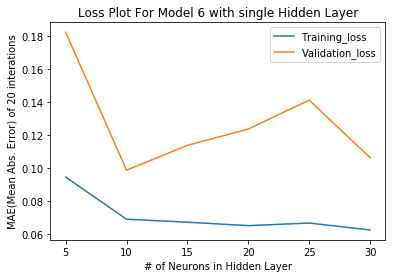

In [35]:

# Plot Training and Validation process for Model 6

plt.plot(n_h, tloss, label='Training_loss')
plt.plot(n_h, vloss,label='Validation_loss')
plt.title("Loss Plot For Model 6 with single Hidden Layer")
plt.xlabel('# of Neurons in Hidden Layer')
plt.ylabel('MAE(Mean Abs. Error) of 20 interations')
plt.legend()

# Report Median absolute error on the validation set per n_h

print("Mean Training Loss:", tloss)
print("Mean Validation Loss:", vloss)

*Comment: The best result belongs to the model with 10 nodes. This time we try we 2 hidden layers and change the n_h set.

In [56]:
# Using two Hidden Layer

tloss=[]   # List of MAE of trainning loss per n_h
vloss=[]   # List of MAE of validation loss per n_h


n_h=[5, 7, 10, 12, 15, 17]    #List of number of neurons in hidden layer

for i in n_h:
    
    model = Sequential()
    model.add(layers.GRU(i, activation='tanh', return_sequences=True, input_shape=(16, 1)))
    model.add(layers.GRU(i, activation='tanh'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=RMSprop(), loss='mae')
   
    train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
    val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_train_steps,
                                  epochs=20, # however many epochs you plan to use
                                  validation_data=val_gen,
                                  validation_steps=num_val_steps)
    
    tloss.append(np.mean(history.history['loss']))
    vloss.append(np.mean(history.history['val_loss']))

Epoch 1/20
540/540 [==============================] - 6s 12ms/step - loss: 0.2887 - val_loss: 0.1718
Epoch 2/20
540/540 [==============================] - 4s 7ms/step - loss: 0.1035 - val_loss: 0.1167
Epoch 3/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0836 - val_loss: 0.0908
Epoch 4/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0665 - val_loss: 0.1064
Epoch 5/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0597 - val_loss: 0.1076
Epoch 6/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0593 - val_loss: 0.1100
Epoch 7/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0586 - val_loss: 0.1098
Epoch 8/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0579 - val_loss: 0.1029
Epoch 9/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0573 - val_loss: 0.0911
Epoch 10/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0564 - val_loss: 0.096

540/540 [==============================] - 4s 8ms/step - loss: 0.0936 - val_loss: 0.0869
Epoch 3/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0821 - val_loss: 0.1296
Epoch 4/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0695 - val_loss: 0.1394
Epoch 5/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0650 - val_loss: 0.1420
Epoch 6/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0625 - val_loss: 0.1306
Epoch 7/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0605 - val_loss: 0.1182
Epoch 8/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0583 - val_loss: 0.1118
Epoch 9/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0558 - val_loss: 0.0917
Epoch 10/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0535 - val_loss: 0.0883
Epoch 11/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0514 - val_loss: 0.0958
Epoch 12/

Mean Training Loss: [0.07083219273222817, 0.07260285413358361, 0.07873942115068158, 0.0694994071914159, 0.06080998728810637, 0.06666469978910214]
Mean Validation Loss: [0.10084431000053881, 0.11598519494136175, 0.11539247830708821, 0.1251114845275879, 0.1335927236949404, 0.12707020146151385]


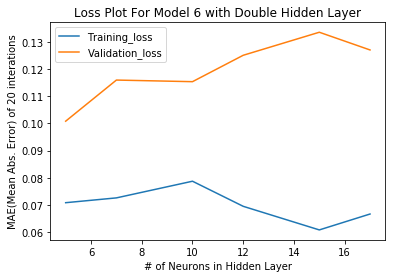

In [57]:
# Plot Training and Validation process for Model 6

plt.plot(n_h, tloss, label='Training_loss')
plt.plot(n_h, vloss,label='Validation_loss')
plt.title("Loss Plot For Model 6 with Double Hidden Layer")
plt.xlabel('# of Neurons in Hidden Layer')
plt.ylabel('MAE(Mean Abs. Error) of 20 interations')
plt.legend()

# Report Median absolute error on the validation set per n_h

print("Mean Training Loss:", tloss)
print("Mean Validation Loss:", vloss)

*Comment: There is an elbow observable at n_h=10. Now, we train a network with double hidden layer and n_h=10

Epoch 1/20
540/540 [==============================] - 8s 14ms/step - loss: 0.2719 - val_loss: 0.1275
Epoch 2/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0903 - val_loss: 0.0881
Epoch 3/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0855 - val_loss: 0.0801
Epoch 4/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0828 - val_loss: 0.0752
Epoch 5/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0800 - val_loss: 0.0895
Epoch 6/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0740 - val_loss: 0.1766
Epoch 7/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0678 - val_loss: 0.1683
Epoch 8/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0644 - val_loss: 0.1622
Epoch 9/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0624 - val_loss: 0.1513
Epoch 10/20
540/540 [==============================] - 4s 7ms/step - loss: 0.0607 - val_loss: 0.143

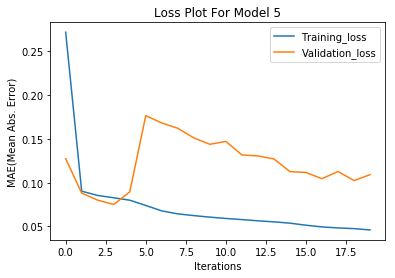

In [58]:
# RNN Model with double hiddent layer and n_h=10

n_h=10   

model = Sequential()
model.add(layers.GRU(n_h, activation='tanh', return_sequences=True, input_shape=(16, 1)))
model.add(layers.GRU(n_h, activation='tanh'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=RMSprop(), loss='mae')
   
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20, # however many epochs you plan to use
                              validation_data=val_gen,
                              validation_steps=num_val_steps)


# Print Model Summary
print(model.summary())

# Plot Training and Validation process for Model 6

plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'],label='Validation_loss')
plt.title("Loss Plot For Model 6")
plt.xlabel('Iterations')
plt.ylabel('MAE(Mean Abs. Error)')
plt.legend()



# Report Median absolute error on the validation set

print("Mean Validation Loss:", np.mean(history.history['val_loss']))
print("Std. Validation Loss:", np.std(history.history['val_loss']))

## Conclusion

Comment on the overall performance of these models. 

- How much of an improvement did you obtain over the baseline? 
- What is the general relative performance of recurrent networks relative to flat networks? 
- What was the effect of using dropout in the RNN network? 
- What was the effect of network architecture, number and size of layers, on performance? Was the effect similar in RNNs and flat networks?

Choose a final model based on your observations above and compare to the baseline model based on the median absolute error on the test set portion of the data. 

The Best models in terms of validation are as follows:

    Model 4: Single layer recurrent neural network with n_h=15
            Mean Validation Loss: 0.11159258550653854
            Std. Validation Loss: 0.01944975452855571

    Model 6: RNN Model with double hiddent layer and n_h=10
            Mean Validation Loss: 0.12265218200782939
            Std. Validation Loss: 0.02846775004631578
            

- Compared to the baseline model with 0.17732154566794633 mean validation loss (MVL), Model 4 performed better with 5% smaller MVL.
- Using dropout made the validation reults worse.
- Size of layers affected the results a lot. However, we could find approximately similar results from a RNN with two different structure. 